<a href="https://www.kaggle.com/code/subhajeetdas/weather-forecasting-of-kolkata?scriptVersionId=132915681" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [1]:
!pip install calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8121 sha256=873cf4bee152f0f7509be44a07d631b9663d62b1682b99f9ced68b83fa07eab4
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calplot
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv


# Load Data

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [3]:
df = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv")
df

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


# Data Cleaning & Visualization

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [4]:
df = df[df["Country"] == "India"]

In [5]:
df.City.unique()

array(['Bombay (Mumbai)', 'Calcutta', 'Chennai (Madras)', 'Delhi'],
      dtype=object)

In [6]:
df = df[df["City"] == "Calcutta"]
df

,Region,Country,State,City,Month,Day,Year,AvgTemperature
321789,Asia,India,NaN,Calcutta,1,1,1995,63.0
321790,Asia,India,NaN,Calcutta,1,2,1995,61.4
321791,Asia,India,NaN,Calcutta,1,3,1995,60.6
321792,Asia,India,NaN,Calcutta,1,4,1995,61.3
321793,Asia,India,NaN,Calcutta,1,5,1995,62.3
...,...,...,...,...,...,...,...,...
331050,Asia,India,NaN,Calcutta,5,9,2020,88.9
331051,Asia,India,NaN,Calcutta,5,10,2020,84.5
331052,Asia,India,NaN,Calcutta,5,11,2020,84.6
331053,Asia,India,NaN,Calcutta,5,12,2020,88.7


In [7]:
df["datetime"] = df.apply(lambda x : datetime.datetime(x["Year"], x["Month"], x["Day"], 0, 0, 0, 0), axis=1)
df.index = df["datetime"].values
df

,Region,Country,State,City,Month,Day,Year,AvgTemperature,datetime
1995-01-01,Asia,India,NaN,Calcutta,1,1,1995,63.0,1995-01-01
1995-01-02,Asia,India,NaN,Calcutta,1,2,1995,61.4,1995-01-02
1995-01-03,Asia,India,NaN,Calcutta,1,3,1995,60.6,1995-01-03
1995-01-04,Asia,India,NaN,Calcutta,1,4,1995,61.3,1995-01-04
1995-01-05,Asia,India,NaN,Calcutta,1,5,1995,62.3,1995-01-05
...,...,...,...,...,...,...,...,...,...
2020-05-09,Asia,India,NaN,Calcutta,5,9,2020,88.9,2020-05-09
2020-05-10,Asia,India,NaN,Calcutta,5,10,2020,84.5,2020-05-10
2020-05-11,Asia,India,NaN,Calcutta,5,11,2020,84.6,2020-05-11
2020-05-12,Asia,India,NaN,Calcutta,5,12,2020,88.7,2020-05-12


In [8]:
df["TempInC"] = df["AvgTemperature"].apply(lambda x : (x-32)/1.8)
df

,Region,Country,State,City,Month,Day,Year,AvgTemperature,datetime,TempInC
1995-01-01,Asia,India,NaN,Calcutta,1,1,1995,63.0,1995-01-01,17.222222
1995-01-02,Asia,India,NaN,Calcutta,1,2,1995,61.4,1995-01-02,16.333333
1995-01-03,Asia,India,NaN,Calcutta,1,3,1995,60.6,1995-01-03,15.888889
1995-01-04,Asia,India,NaN,Calcutta,1,4,1995,61.3,1995-01-04,16.277778
1995-01-05,Asia,India,NaN,Calcutta,1,5,1995,62.3,1995-01-05,16.833333
...,...,...,...,...,...,...,...,...,...,...
2020-05-09,Asia,India,NaN,Calcutta,5,9,2020,88.9,2020-05-09,31.611111
2020-05-10,Asia,India,NaN,Calcutta,5,10,2020,84.5,2020-05-10,29.166667
2020-05-11,Asia,India,NaN,Calcutta,5,11,2020,84.6,2020-05-11,29.222222
2020-05-12,Asia,India,NaN,Calcutta,5,12,2020,88.7,2020-05-12,31.500000


In [9]:
df.dtypes

Region                    object
Country                   object
State                     object
City                      object
Month                      int64
Day                        int64
Year                       int64
AvgTemperature           float64
datetime          datetime64[ns]
TempInC                  float64
dtype: object

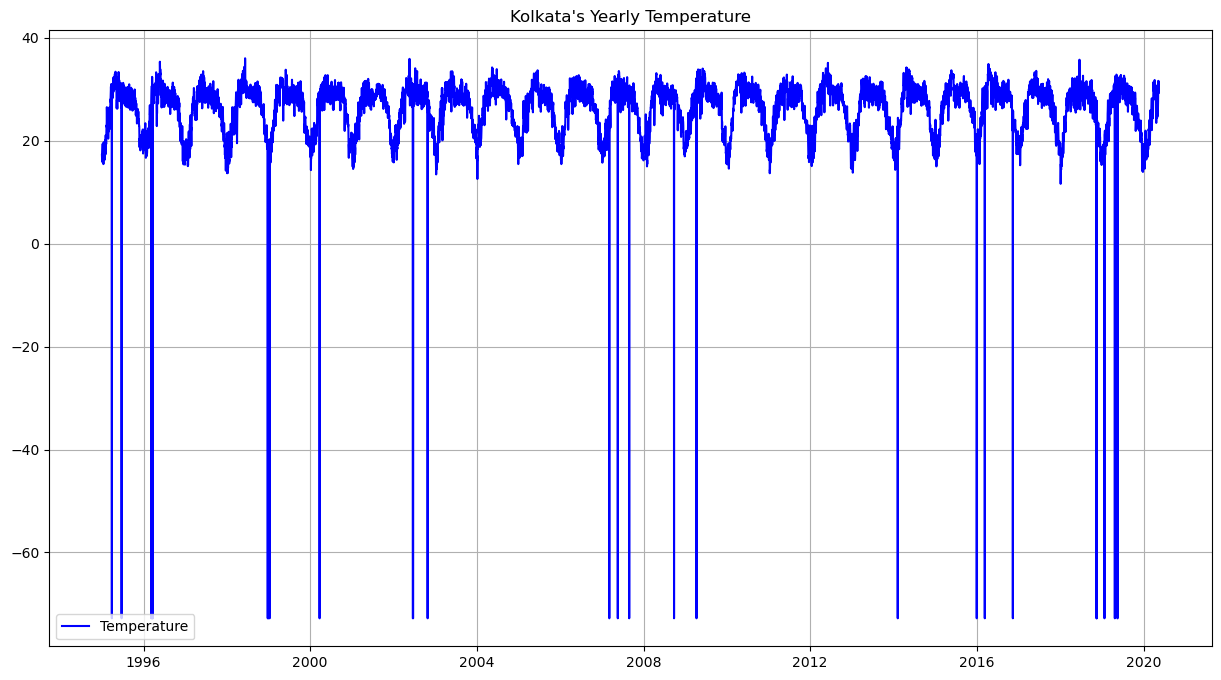

In [10]:
plt.figure(figsize=(15, 8))
plt.title("Kolkata's Yearly Temperature")
plt.plot(df['datetime'], df['TempInC'], color = 'blue', linewidth = 1.5, label = "Temperature")
plt.grid()
plt.legend(loc ="lower left")

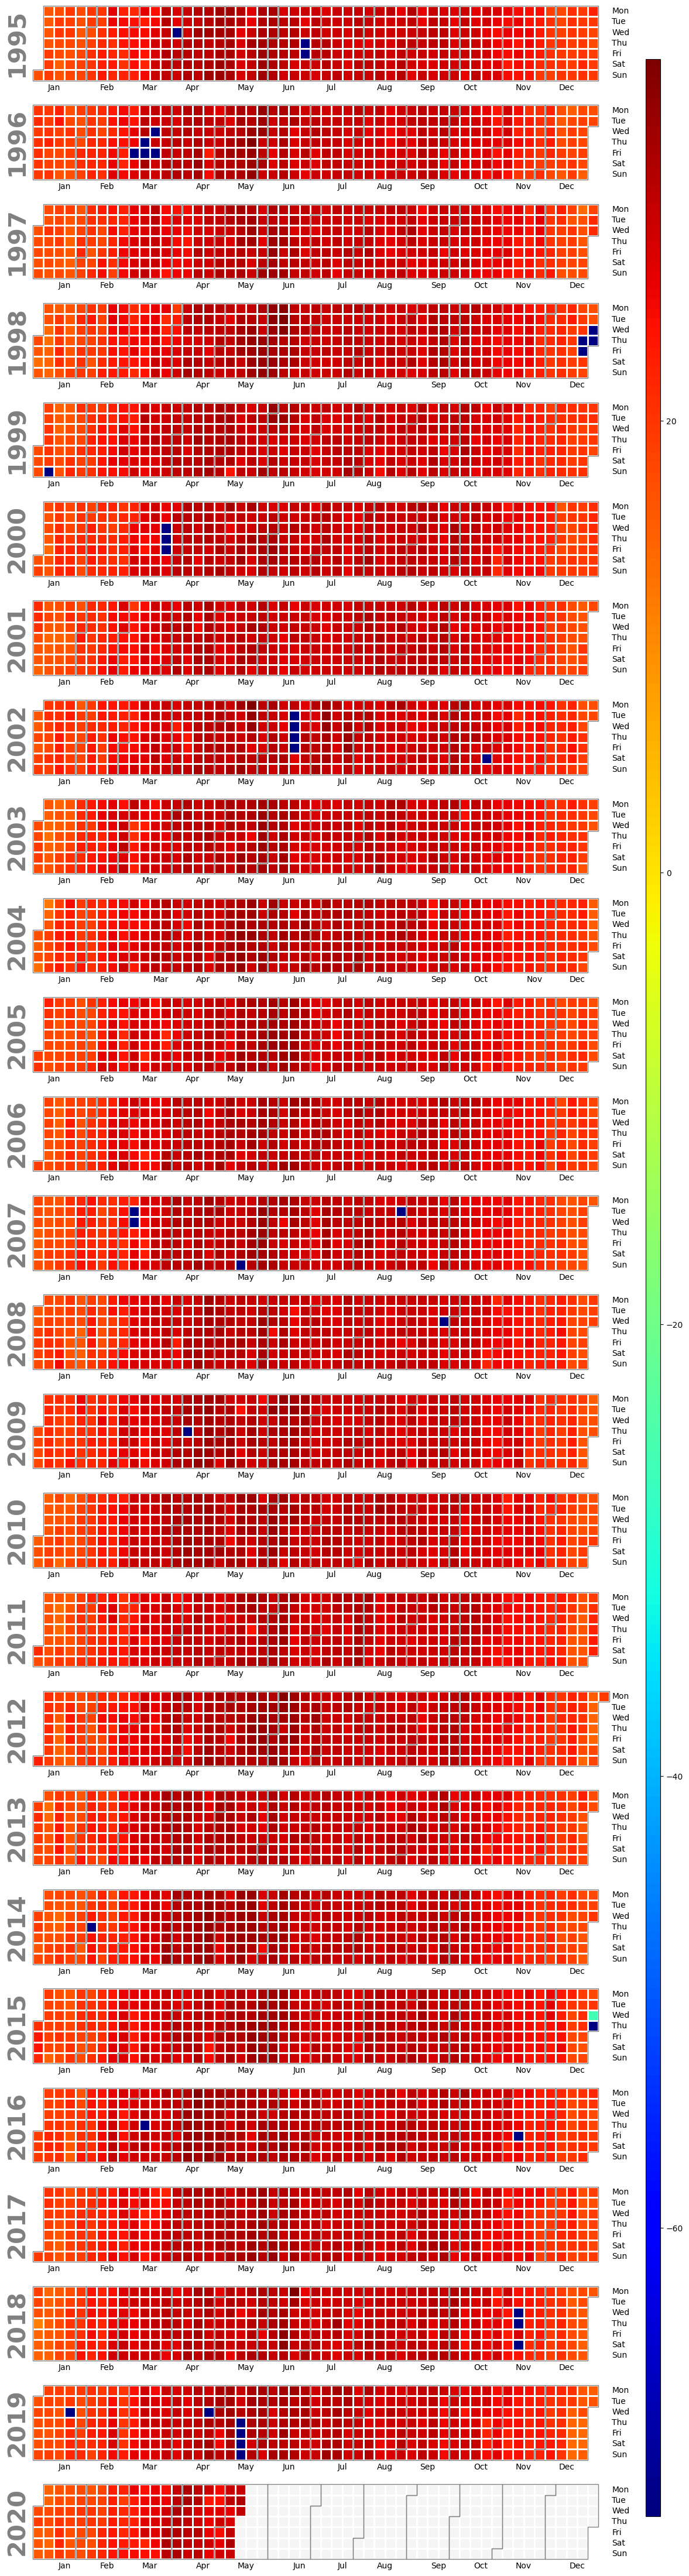

In [11]:
fig = calplot.calplot(df["TempInC"], how = "mean", cmap='jet')

## Making a New Dataframe with Date & Temperature in Celsius Only for the Prophet Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [12]:
n_df = df[['datetime', 'TempInC']]
n_df

,datetime,TempInC
1995-01-01,1995-01-01,17.222222
1995-01-02,1995-01-02,16.333333
1995-01-03,1995-01-03,15.888889
1995-01-04,1995-01-04,16.277778
1995-01-05,1995-01-05,16.833333
...,...,...
2020-05-09,2020-05-09,31.611111
2020-05-10,2020-05-10,29.166667
2020-05-11,2020-05-11,29.222222
2020-05-12,2020-05-12,31.500000


In [13]:
n_df.rename(columns = {'datetime' :'ds', 'TempInC' : 'y'}, inplace = True)

# Prophet Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid blue">

In [14]:
model = Prophet()
model.fit(n_df)

08:44:25 - cmdstanpy - INFO - Chain [1] start processing
08:44:25 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
df_future = model.make_future_dataframe(periods = 850)
forecast = model.predict(df_future)

In [16]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1995-01-01,25.209713,8.163459,25.365933,25.209713,25.209713,-8.943969,-8.943969,-8.943969,0.222740,0.222740,0.222740,-9.166709,-9.166709,-9.166709,0.0,0.0,0.0,16.265744
1,1995-01-02,25.210096,8.056119,24.825225,25.210096,25.210096,-8.707168,-8.707168,-8.707168,0.433554,0.433554,0.433554,-9.140721,-9.140721,-9.140721,0.0,0.0,0.0,16.502928
2,1995-01-03,25.210479,7.410085,24.581465,25.210479,25.210479,-8.855980,-8.855980,-8.855980,0.241708,0.241708,0.241708,-9.097688,-9.097688,-9.097688,0.0,0.0,0.0,16.354499
3,1995-01-04,25.210862,7.129213,24.565113,25.210862,25.210862,-9.413265,-9.413265,-9.413265,-0.373623,-0.373623,-0.373623,-9.039642,-9.039642,-9.039642,0.0,0.0,0.0,15.797597
4,1995-01-05,25.211245,7.451807,24.501707,25.211245,25.211245,-9.456647,-9.456647,-9.456647,-0.487893,-0.487893,-0.487893,-8.968754,-8.968754,-8.968754,0.0,0.0,0.0,15.754598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110,2022-09-06,24.342244,18.182901,35.532015,24.281572,24.395438,2.750520,2.750520,2.750520,0.241708,0.241708,0.241708,2.508811,2.508811,2.508811,0.0,0.0,0.0,27.092764
10111,2022-09-07,24.341409,17.631448,35.334808,24.280731,24.394664,2.121287,2.121287,2.121287,-0.373623,-0.373623,-0.373623,2.494910,2.494910,2.494910,0.0,0.0,0.0,26.462696
10112,2022-09-08,24.340574,17.760635,34.697845,24.279903,24.393890,2.001725,2.001725,2.001725,-0.487893,-0.487893,-0.487893,2.489618,2.489618,2.489618,0.0,0.0,0.0,26.342299
10113,2022-09-09,24.339739,17.794749,35.487527,24.279075,24.393115,2.236822,2.236822,2.236822,-0.256092,-0.256092,-0.256092,2.492913,2.492913,2.492913,0.0,0.0,0.0,26.576560


In [17]:
pred = forecast.copy()

## Forecsting the Temperature

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid blue">

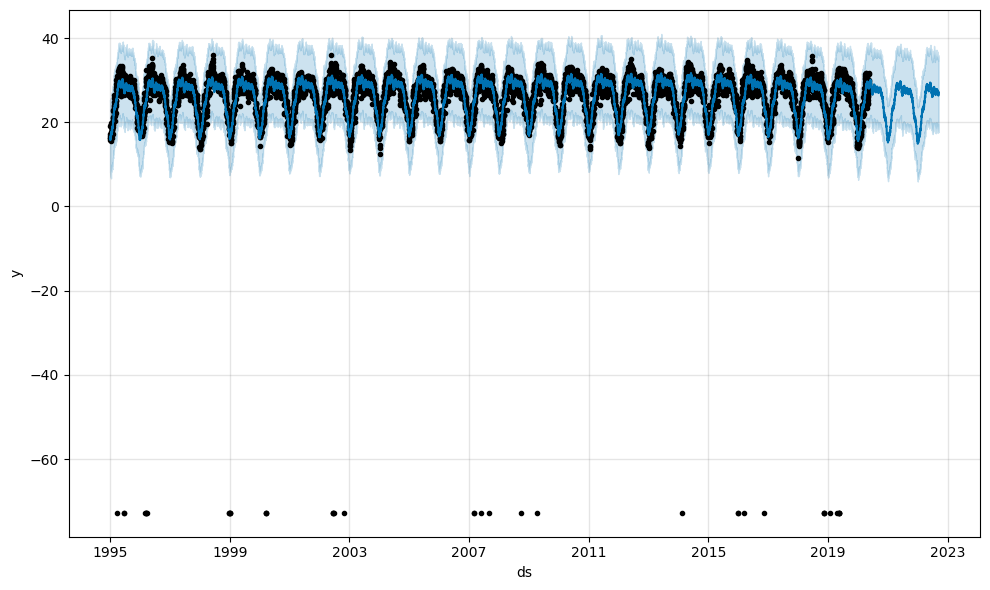

In [18]:
figure1 = model.plot(forecast)

In [19]:
plot_plotly(model, forecast)

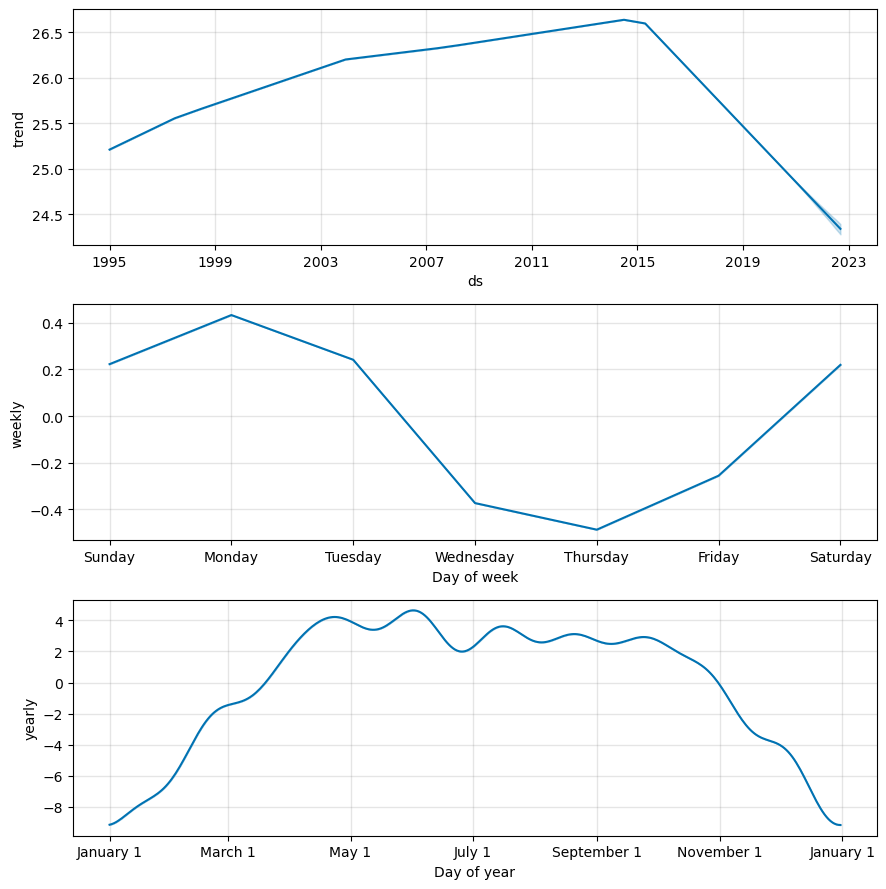

In [20]:
figure2 = model.plot_components(forecast)

In [21]:
plot_components_plotly(model, forecast)

In [22]:
pred.index = pred["ds"].values

In [23]:
pred = pred[pred["ds"] > "2020-05-13"]
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2020-05-14,2020-05-14,25.048018,20.087150,36.943195,25.048018,25.048018,2.933924,2.933924,2.933924,-0.487893,-0.487893,-0.487893,3.421817,3.421817,3.421817,0.0,0.0,0.0,27.981942
2020-05-15,2020-05-15,25.047183,18.958316,37.430677,25.047183,25.047183,3.196766,3.196766,3.196766,-0.256092,-0.256092,-0.256092,3.452857,3.452857,3.452857,0.0,0.0,0.0,28.243949
2020-05-16,2020-05-16,25.046348,20.155365,37.374388,25.046348,25.046348,3.716297,3.716297,3.716297,0.219606,0.219606,0.219606,3.496691,3.496691,3.496691,0.0,0.0,0.0,28.762645
2020-05-17,2020-05-17,25.045513,19.916945,37.383865,25.045513,25.045513,3.775450,3.775450,3.775450,0.222740,0.222740,0.222740,3.552710,3.552710,3.552710,0.0,0.0,0.0,28.820963
2020-05-18,2020-05-18,25.044678,20.681258,38.187728,25.044678,25.044678,4.053523,4.053523,4.053523,0.433554,0.433554,0.433554,3.619969,3.619969,3.619969,0.0,0.0,0.0,29.098200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-06,2022-09-06,24.342244,18.182901,35.532015,24.281572,24.395438,2.750520,2.750520,2.750520,0.241708,0.241708,0.241708,2.508811,2.508811,2.508811,0.0,0.0,0.0,27.092764
2022-09-07,2022-09-07,24.341409,17.631448,35.334808,24.280731,24.394664,2.121287,2.121287,2.121287,-0.373623,-0.373623,-0.373623,2.494910,2.494910,2.494910,0.0,0.0,0.0,26.462696
2022-09-08,2022-09-08,24.340574,17.760635,34.697845,24.279903,24.393890,2.001725,2.001725,2.001725,-0.487893,-0.487893,-0.487893,2.489618,2.489618,2.489618,0.0,0.0,0.0,26.342299
2022-09-09,2022-09-09,24.339739,17.794749,35.487527,24.279075,24.393115,2.236822,2.236822,2.236822,-0.256092,-0.256092,-0.256092,2.492913,2.492913,2.492913,0.0,0.0,0.0,26.576560


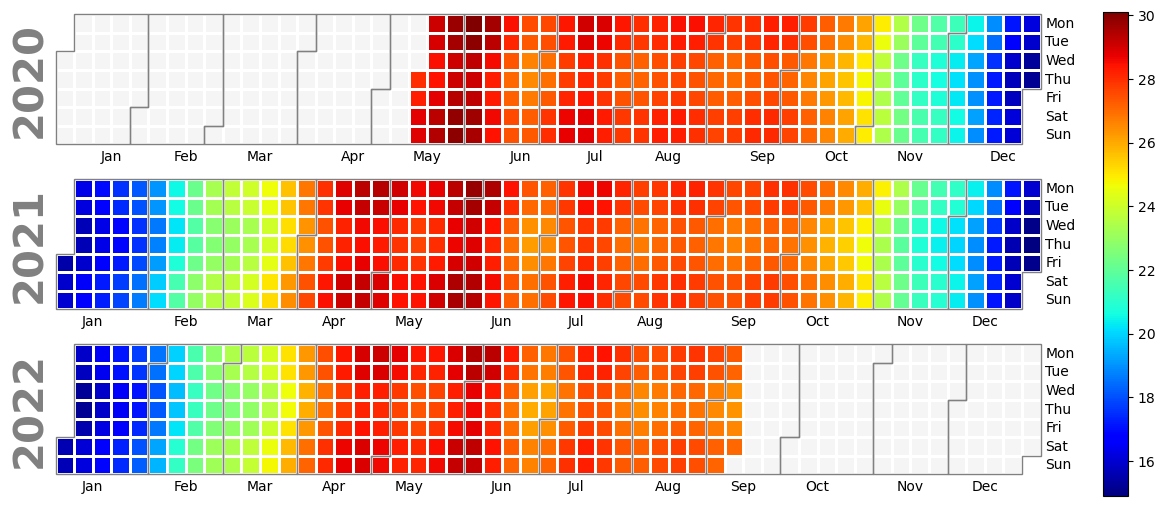

In [24]:
fig2 = calplot.calplot(pred["yhat"], how = "mean", cmap='jet')

# Performnce Measurement of the Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid green">

In [25]:
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon = '365 days')

  0%|          | 0/44 [00:00<?, ?it/s]

08:44:37 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:38 - cmdstanpy - INFO - Chain [1] done processing
08:44:39 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:40 - cmdstanpy - INFO - Chain [1] start processing
08:44:40 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing
08:44:42 - cmdstanpy - INFO - Chain [1] start processing
08:44:42 - cmdstanpy - INFO - Chain [1] done processing
08:44:43 - cmdstanpy - INFO - Chain [1] start processing
08:44:43 - cmdstanpy - INFO - Chain [1] done processing
08:44:44 - cmdstanpy - INFO - Chain [1] start processing
08:44:44 - cmdstanpy - INFO - Chain [1] done processing
08:44:45 - cmdstanpy - INFO - Chain [1] start processing
08:44:46 - cmdstanpy - INFO - Chain [1]

In [26]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1998-03-06,20.171708,10.033817,30.567160,26.500000,1998-03-05
1,1998-03-07,22.196998,11.059280,32.354059,23.888889,1998-03-05
2,1998-03-08,21.767790,11.038215,33.423393,21.277778,1998-03-05
3,1998-03-09,21.578223,11.383519,32.285249,23.333333,1998-03-05
4,1998-03-10,21.364312,10.680969,32.051376,25.333333,1998-03-05
...,...,...,...,...,...,...
16057,2020-05-09,29.985757,22.122601,37.840653,31.611111,2019-05-14
16058,2020-05-10,30.002765,21.603170,38.769917,29.166667,2019-05-14
16059,2020-05-11,30.165275,21.080657,38.015125,29.222222,2019-05-14
16060,2020-05-12,30.006821,21.891825,38.286762,31.500000,2019-05-14


In [27]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,65.139998,8.070935,2.358173,0.079697,0.052614,0.085285,0.993151
1,38 days,58.745078,7.664534,2.299515,0.078921,0.052179,0.084150,0.993802
2,39 days,49.512344,7.036501,2.217796,0.077907,0.052750,0.082651,0.994721
3,40 days,42.938776,6.552769,2.157194,0.077091,0.052780,0.081507,0.995344
4,41 days,36.323263,6.026878,2.100466,0.076431,0.052750,0.080503,0.995967


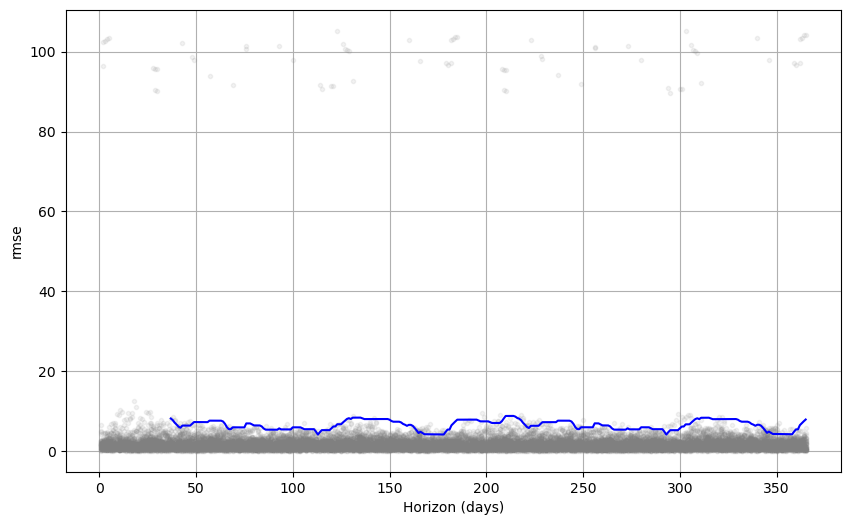

In [28]:
figure3 = plot_cross_validation_metric(df_cv, metric='rmse')

# Saving the Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid green">

In [29]:
with open('Weather_Kolkata_Prophet_Model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

#with open('Weather_Kolkata_Prophet_Model.json', 'r') as fin:
    #model = model_from_json(fin.read())  # Load model